
Estado cuántico final (amplitudes de los estados):
Statevector([ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
            dims=(2, 2))


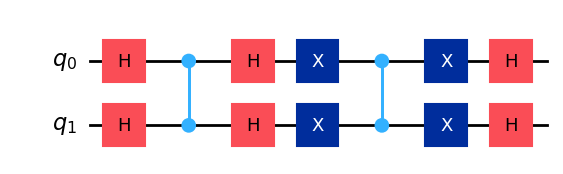

In [11]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

grover_circuit = QuantumCircuit(2)
grover_circuit.draw(output="mpl")
grover_circuit.h([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.h([0, 1])
grover_circuit.x([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.x([0, 1])
grover_circuit.h([0, 1])

final_state = Statevector.from_instruction(grover_circuit)

# Paso 6: Ver el resultado
print("\nEstado cuántico final (amplitudes de los estados):")
print(final_state)
grover_circuit.draw(output="mpl")

